## Assignment: predicting house prices

Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

* Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:

```python
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
```

* Please follow the example above and call `engine.dispose()` when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.
* Investigate the data, and do any necessary data cleaning.
* Explore the data and find some variables that you think would be useful in predicting house prices.
* Build your initial model using these features and estimate the parameters using OLS.


Spend up to 4 hours on this assignment. When you are done and have submitted a link to your notebook below, feel free to take a look at [this example solution](https://github.com/Thinkful-Ed/machine-learning-regression-problems/blob/master/notebooks/2.solution_simple_linear_regression_models.ipynb).



### Import modules and dataset

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from scipy.stats import mode

In [2]:
#credentials
user = 'dsbc_student'
pw = '7*.8G9QH21'
host = '142.93.121.174'
port = '5432'
db = 'houseprices'
dialect = 'postgresql'

In [3]:
engine = create_engine('{}://{}:{}@{}:{}/{}'.format(dialect, user, pw, host, port, db))
engine.table_names()

['houseprices']

In [4]:
sql_query = '''
SELECT
    *
FROM
    houseprices
'''
source_df = pd.read_sql(sql_query, con=engine)
engine.dispose()

In [5]:
house_df = source_df.copy()

In [6]:
house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


## Investigate columns and look for missing values

In [7]:
house_df.columns[house_df.dtypes== 'object']

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')

In [8]:
for column in house_df.columns[house_df.dtypes== 'object']:
    print("Column {} has values {}".format(column, house_df[column].unique()))

Column mszoning has values ['RL' 'RM' 'C (all)' 'FV' 'RH']
Column street has values ['Pave' 'Grvl']
Column alley has values [None 'Grvl' 'Pave']
Column lotshape has values ['Reg' 'IR1' 'IR2' 'IR3']
Column landcontour has values ['Lvl' 'Bnk' 'Low' 'HLS']
Column utilities has values ['AllPub' 'NoSeWa']
Column lotconfig has values ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Column landslope has values ['Gtl' 'Mod' 'Sev']
Column neighborhood has values ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Column condition1 has values ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Column condition2 has values ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
Column bldgtype has values ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
Column housestyle has values ['2Story' '1Stor

In [9]:
house_df.isna().sum()[house_df.isna().sum() >0] 

lotfrontage      259
alley           1369
masvnrtype         8
masvnrarea         8
bsmtqual          37
bsmtcond          37
bsmtexposure      38
bsmtfintype1      37
bsmtfintype2      38
electrical         1
fireplacequ      690
garagetype        81
garageyrblt       81
garagefinish      81
garagequal        81
garagecond        81
poolqc          1453
fence           1179
miscfeature     1406
dtype: int64

In [10]:
house_df.dtypes[house_df.isna().sum() >0]

lotfrontage     float64
alley            object
masvnrtype       object
masvnrarea      float64
bsmtqual         object
bsmtcond         object
bsmtexposure     object
bsmtfintype1     object
bsmtfintype2     object
electrical       object
fireplacequ      object
garagetype       object
garageyrblt     float64
garagefinish     object
garagequal       object
garagecond       object
poolqc           object
fence            object
miscfeature      object
dtype: object

In [11]:
#fillvalues
missing_numerical = ['lotfrontage', 'masvnrarea', 'garageyrblt']
for miss in missing_numerical: #column-wise
    house_df[miss] = house_df[miss].fillna(house_df[miss].mean()) #fill with column mean
    
missing_cat_ob = house_df.dtypes[house_df.isna().sum() > 0]
missing_categorical = missing_cat_ob[missing_cat_ob == 'object'].index
for miss in missing_categorical:
    house_df[miss] = house_df[miss].fillna(house_df[miss].value_counts().index[0])  #fill with most common value
    house_df[miss]

In [12]:
categorical_feat = house_df.dtypes[house_df.dtypes == 'object'].index
new_categories_df = pd.DataFrame()
for feature in categorical_feat:
    new_categories_df = pd.concat([new_categories_df, 
                                   pd.get_dummies(house_df[feature], columns=categorical_feat, drop_first=True)], axis=1)
new_categories_df = pd.concat([new_categories_df, 
                               house_df.filter(items=(house_df.columns[(house_df.dtypes.values != 'object').tolist()]), axis=1) ], 
                              axis=1) #tolist() needed to avoid hashability issue

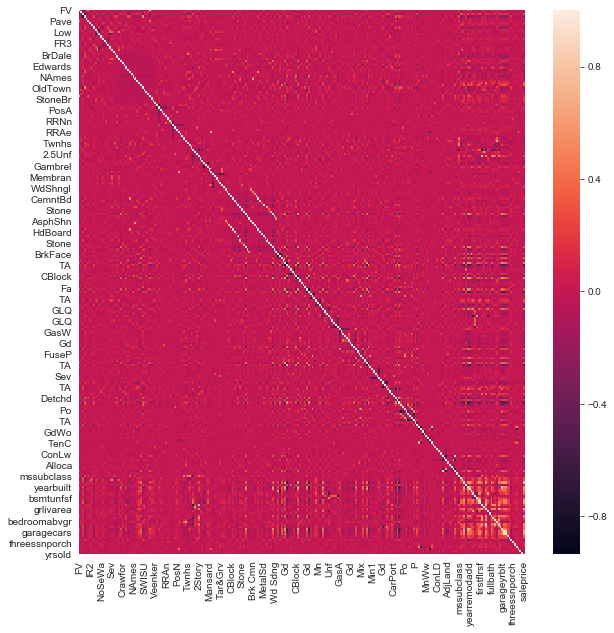

In [13]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,10)) 
sns.heatmap(new_categories_df.corr());

### PCA

In [14]:
#Find highly (>.95) correlated values and drop
house_corr_df = house_df.corr()
house_corr_df[house_corr_df >.95].notna()#.any()

#not sure how to find individual variables to pull out as multicollinear

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
id,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
mssubclass,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
lotfrontage,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
lotarea,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
overallqual,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
overallcond,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yearbuilt,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yearremodadd,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
masvnrarea,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
bsmtfinsf1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [15]:
#standardize data and compute PCA
pca = PCA()
scaler = StandardScaler()
X = scaler.fit_transform(new_categories_df.drop(["saleprice"], axis=1))
y = new_categories_df.saleprice

In [16]:
pca.fit(X)
pca.explained_variance_ratio_

array([6.57436517e-02, 3.07343944e-02, 2.41361203e-02, 2.08597462e-02,
       1.66930826e-02, 1.58181372e-02, 1.47386147e-02, 1.36415467e-02,
       1.35777320e-02, 1.23354609e-02, 1.21611344e-02, 1.16966982e-02,
       1.12524498e-02, 1.11798208e-02, 1.07838535e-02, 1.03464712e-02,
       1.02796697e-02, 1.00157230e-02, 9.93499648e-03, 9.45192984e-03,
       9.23509200e-03, 9.02146466e-03, 8.95688570e-03, 8.70677596e-03,
       8.66453644e-03, 8.38597203e-03, 8.16591399e-03, 8.15022337e-03,
       8.04943176e-03, 7.76708732e-03, 7.69813690e-03, 7.62703723e-03,
       7.52720077e-03, 7.32496009e-03, 7.20854457e-03, 7.11313976e-03,
       6.99289485e-03, 6.96162685e-03, 6.92669250e-03, 6.81085471e-03,
       6.76849409e-03, 6.60592548e-03, 6.58043248e-03, 6.40913375e-03,
       6.30180219e-03, 6.26098971e-03, 6.19429596e-03, 6.10741750e-03,
       5.97221857e-03, 5.94973476e-03, 5.86164350e-03, 5.79343502e-03,
       5.76727276e-03, 5.63234367e-03, 5.60691145e-03, 5.57649325e-03,
      

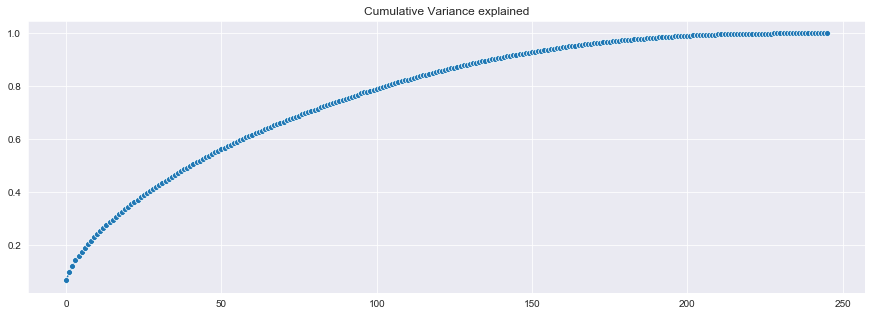

In [17]:
sns.set_style('darkgrid')
plt.figure(figsize=(15,5))
sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.title("Cumulative Variance explained");

In [18]:
pca_75 = PCA(n_components=75)
X_pca = pca_75.fit_transform(X)
lrm = linear_model.LinearRegression()
lrm.fit(X_pca, y)
lrm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [15293.71402299  3213.28134743 10710.67037556  4570.55337648
   105.28403894  5793.67672872 -5893.85541478  1310.66391702
 -1690.94486279 -2818.09194761 -1004.10107523  1626.47915392
  -478.66249418   603.61638933   439.3682275    967.44621502
  -622.84874116 -1324.56575105  1880.89386513   379.34077666
   250.71119524 -1445.22024812   902.54270794  2664.29601906
 -1380.32184288 -1554.66181381 -1558.93536907  2689.95174579
  3421.89986799  1496.05649774  -849.7607586    148.65029051
   -76.75244252  1672.06824134  4524.74866596    75.42601729
  -577.93997106  -629.58117735 -1806.31776186   987.15536907
  1552.44135389  -708.13228883  2340.27624811  2359.71167745
  2206.43139622   840.20994026  1223.44802868 -1833.94282466
  1938.88045642 -1703.22875926  2177.05874945 -2672.94779175
   675.19124131 -2202.81240115  -294.17982511  1765.31556578
  -918.10534231 -2423.01373512    99.00483012  3943.96072072
 -1479.34807735  1909.209077    1678.8673585   -291.35633697
  -851.